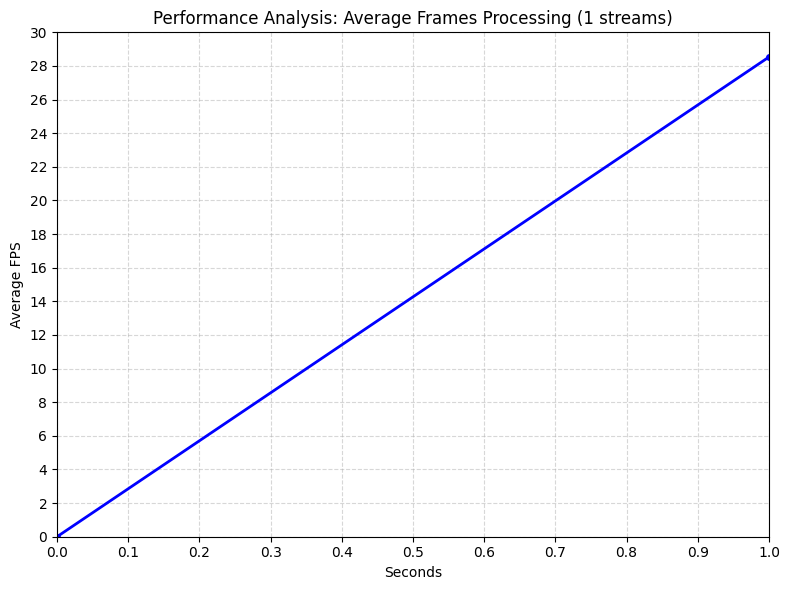


Statistics for 1 streams:
Average Latency: 9.0 ms
Average GPU Utilization: 17.3%
Average GPU Memory Utilization: 21.0%
Average FPS: 28.5
--------------------------------------------------


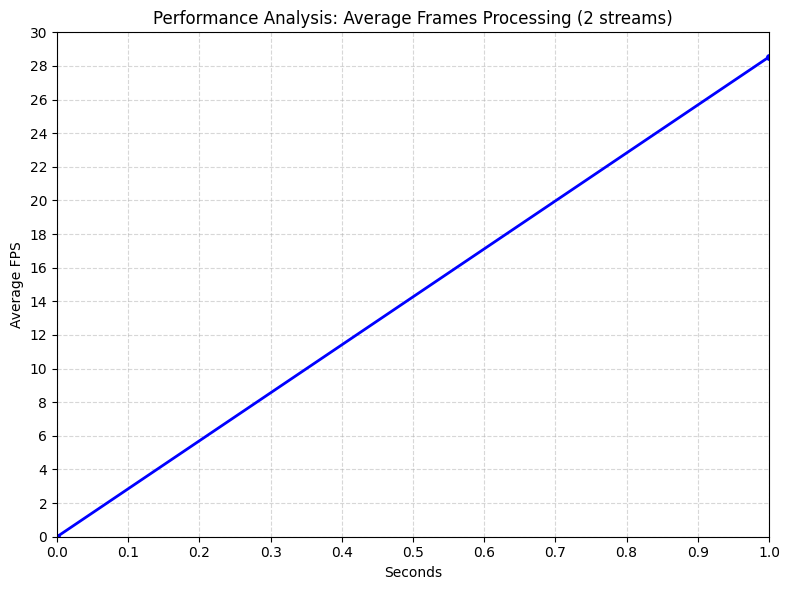


Statistics for 2 streams:
Average Latency: 8.9 ms
Average GPU Utilization: 20.7%
Average GPU Memory Utilization: 26.0%
Average FPS: 28.5
--------------------------------------------------


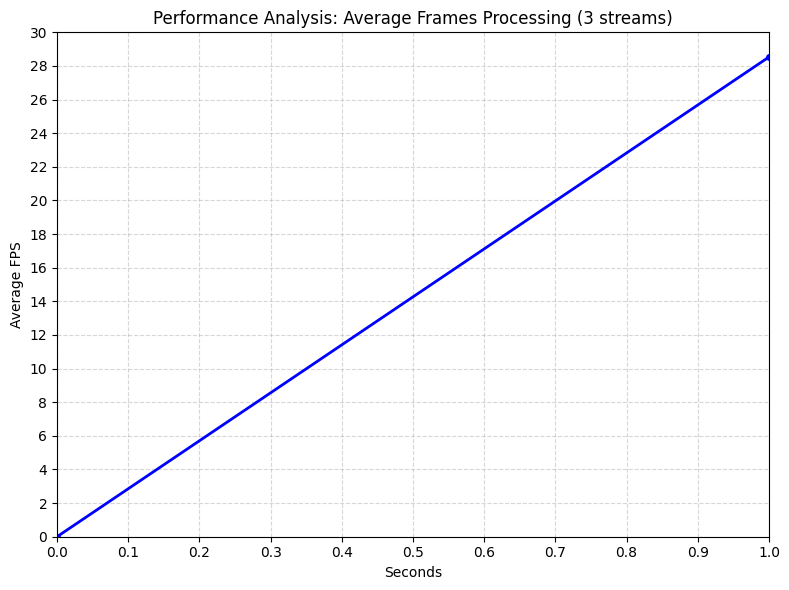


Statistics for 3 streams:
Average Latency: 9.2 ms
Average GPU Utilization: 31.7%
Average GPU Memory Utilization: 32.0%
Average FPS: 28.5
--------------------------------------------------


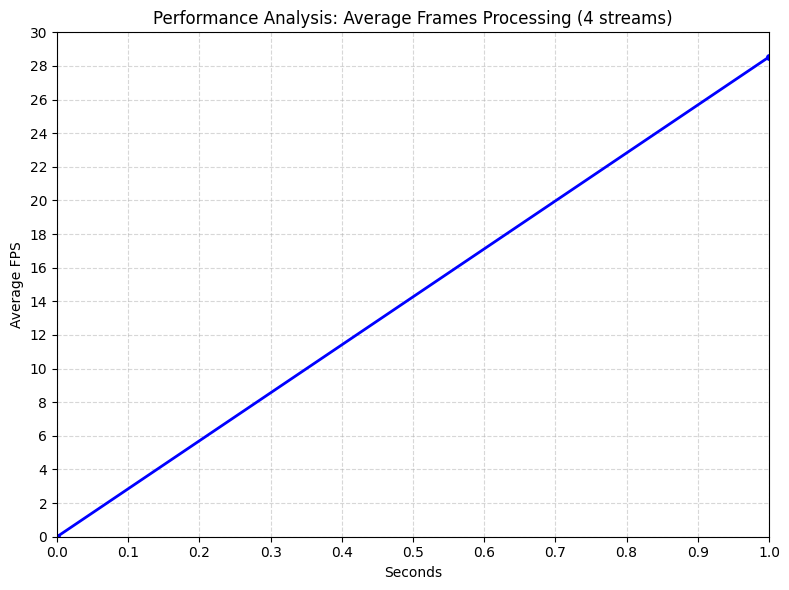


Statistics for 4 streams:
Average Latency: 9.1 ms
Average GPU Utilization: 36.0%
Average GPU Memory Utilization: 38.0%
Average FPS: 28.5
--------------------------------------------------


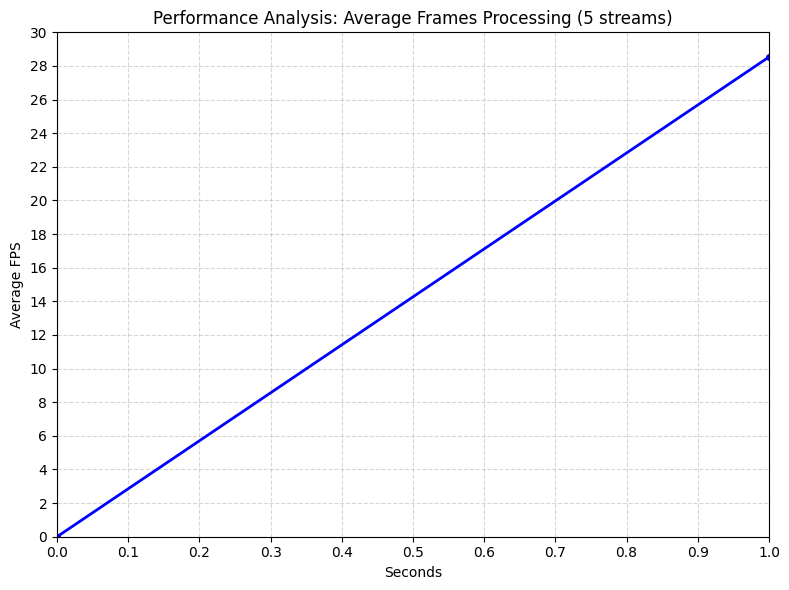


Statistics for 5 streams:
Average Latency: 9.0 ms
Average GPU Utilization: 44.0%
Average GPU Memory Utilization: 43.0%
Average FPS: 28.5
--------------------------------------------------


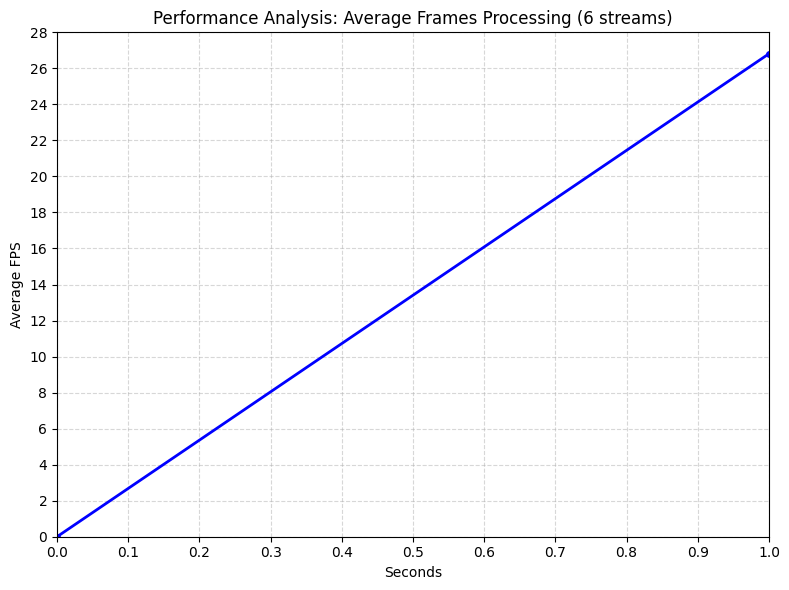


Statistics for 6 streams:
Average Latency: 9.1 ms
Average GPU Utilization: 41.8%
Average GPU Memory Utilization: 46.2%
Average FPS: 26.8
--------------------------------------------------


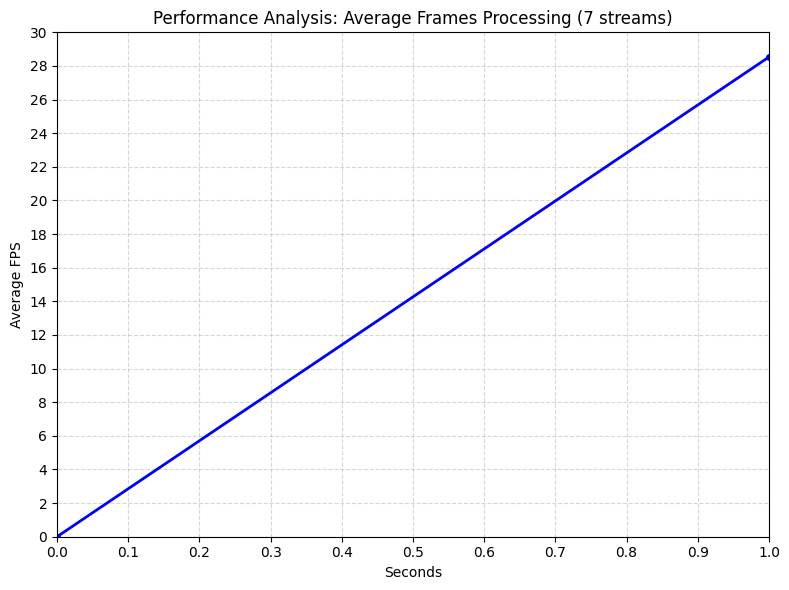


Statistics for 7 streams:
Average Latency: 9.2 ms
Average GPU Utilization: 63.3%
Average GPU Memory Utilization: 54.7%
Average FPS: 28.5
--------------------------------------------------


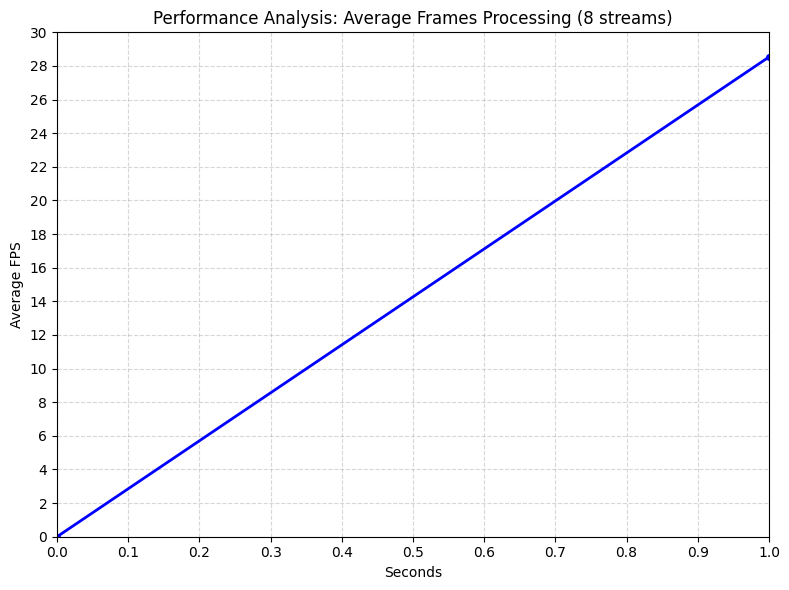


Statistics for 8 streams:
Average Latency: 9.3 ms
Average GPU Utilization: 71.3%
Average GPU Memory Utilization: 60.0%
Average FPS: 28.5
--------------------------------------------------


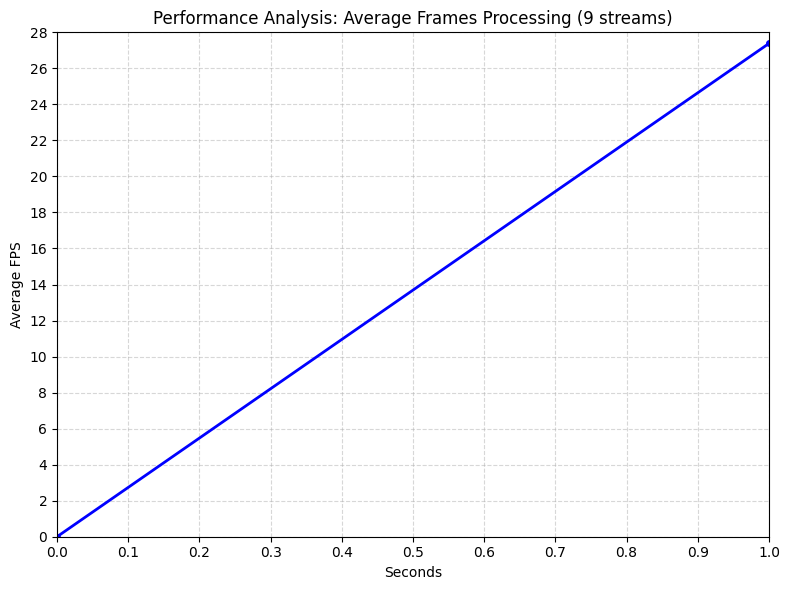


Statistics for 9 streams:
Average Latency: 9.4 ms
Average GPU Utilization: 68.5%
Average GPU Memory Utilization: 64.8%
Average FPS: 27.4
--------------------------------------------------


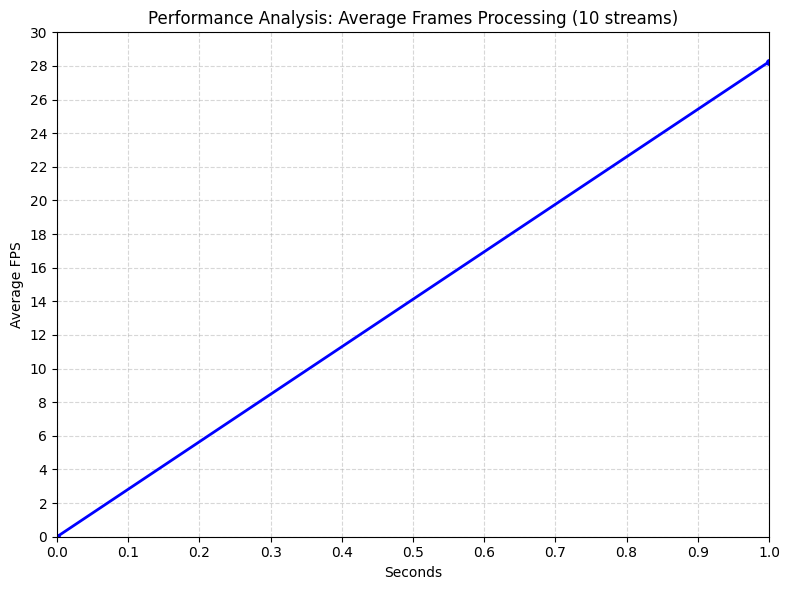


Statistics for 10 streams:
Average Latency: 9.6 ms
Average GPU Utilization: 87.7%
Average GPU Memory Utilization: 72.0%
Average FPS: 28.2
--------------------------------------------------


In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict
from datetime import datetime


def parse_log_for_timeline(log_file_path):
    """Parse the performance log and extract timeline data for each stream count test."""
    test_data = defaultdict(list)
    gpu_data = defaultdict(list)
    
    with open(log_file_path, 'r') as f:
        lines = f.readlines()
    
    current_test_streams = None
    test_start_time = None
    
    for line in lines:
        try:
            log_entry = json.loads(line.strip())
            timestamp = log_entry["timestamp"]
            
            # Extract number of streams from initialization messages
            if "Initialized" in log_entry.get("fields", {}).get("message", ""):
                match = re.search(r"Initialized (\d+) processors", log_entry["fields"]["message"])
                if match:
                    current_test_streams = int(match.group(1))
                    test_start_time = timestamp
            
            # Extract inference statistics
            if (log_entry.get("target") == "client::inference::source" and 
                "inference statistics" in log_entry.get("fields", {}).get("message", "") and
                current_test_streams is not None and test_start_time is not None):
                
                fields = log_entry["fields"]
                if fields.get('avg_processing', 0) > 0:  # Only include valid processing entries
                    # Calculate time from test start
                    log_time = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
                    start_time = datetime.fromisoformat(test_start_time.replace('Z', '+00:00'))
                    seconds_from_start = (log_time - start_time).total_seconds()
                    
                    test_data[current_test_streams].append({
                        'timestamp': timestamp,
                        'seconds_from_start': seconds_from_start,
                        'total_success': fields.get('total_success', 0),
                        'total_expected': fields.get('total_expected', 0),
                        'avg_processing': fields.get('avg_processing', 0)
                    })
            
            # Extract GPU utilization data
            if ("GPU utilization information" in log_entry.get("fields", {}).get("message", "") and
                current_test_streams is not None and test_start_time is not None):
                
                fields = log_entry["fields"]
                log_time = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
                start_time = datetime.fromisoformat(test_start_time.replace('Z', '+00:00'))
                seconds_from_start = (log_time - start_time).total_seconds()
                
                gpu_data[current_test_streams].append({
                    'seconds_from_start': seconds_from_start,
                    'util_perc': fields.get('util_perc', 0),
                    'memory_perc': fields.get('memory_perc', 0)
                })
                
        except (json.JSONDecodeError, KeyError, ValueError):
            continue
    
    return test_data, gpu_data


def calculate_fps_timeline(test_data):
    """Calculate average FPS for 0-1 second timeline for each stream count test."""
    fps_timelines = {}
    
    for stream_count, data in test_data.items():
        if not data:
            continue
            
        # Sort by time
        data.sort(key=lambda x: x['seconds_from_start'])
        
        # Calculate overall average FPS for the test
        all_fps = [entry['total_success'] for entry in data]
        avg_fps = np.mean(all_fps) if all_fps else 0
        
        # Create simple 0-1 second timeline with average FPS
        times = [0, 1]
        fps_values = [0, avg_fps]  # Start at 0, reach average at 1 second
        
        fps_timelines[stream_count] = {
            'times': times,
            'fps': fps_values,
            'avg_fps': avg_fps,
            'avg_latency_ms': np.mean([entry['avg_processing'] for entry in data]) / 1000,  # Convert to ms
            'data': data
        }
    
    return fps_timelines


def plot_fps_timelines(log_file_path):
    """Create FPS timeline plots for each stream count test."""
    
    # Parse the log file
    test_data, gpu_data = parse_log_for_timeline(log_file_path)
    
    if not test_data:
        print("No test data found in log file")
        return
    
    # Calculate FPS timelines
    fps_timelines = calculate_fps_timeline(test_data)
    
    # Create plots for each stream count
    for stream_count in sorted(fps_timelines.keys()):
        timeline = fps_timelines[stream_count]
        
        # Create the plot with square dimensions
        plt.figure(figsize=(8, 6))
        
        # Plot FPS timeline
        plt.plot(timeline['times'], timeline['fps'], 'b-', linewidth=2, marker='o', markersize=4)
        
        # Customize the plot
        plt.xlabel("Seconds", fontsize=10)
        plt.ylabel("Average FPS", fontsize=10)
        plt.title(f"Performance Analysis: Average Frames Processing ({stream_count} streams)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # Set x-axis to show from 0 to 1 second with 0.1 intervals
        plt.xlim(0, 1)
        plt.xticks(np.arange(0, 1.1, 0.1))
        
        # Set y-axis ticks in steps of 2 FPS, starting from 0
        if timeline['fps']:
            max_fps = max(timeline['fps'])
            y_max = int(np.ceil(max_fps / 2) * 2)  # Round up to nearest multiple of 2
            plt.yticks(np.arange(0, y_max + 2, 2))
            plt.ylim(0, y_max)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and print statistics
        gpu_stats = gpu_data.get(stream_count, [])
        if gpu_stats:
            avg_gpu_util = np.mean([entry['util_perc'] for entry in gpu_stats])
            avg_gpu_memory = np.mean([entry['memory_perc'] for entry in gpu_stats])
        else:
            avg_gpu_util = 0
            avg_gpu_memory = 0
        
        print(f"\nStatistics for {stream_count} streams:")
        print(f"Average Latency: {timeline['avg_latency_ms']:.1f} ms")
        print(f"Average GPU Utilization: {avg_gpu_util:.1f}%")
        print(f"Average GPU Memory Utilization: {avg_gpu_memory:.1f}%")
        print(f"Average FPS: {timeline['avg_fps']:.1f}")
        print("-" * 50)


if __name__ == "__main__":
    # Replace with your log file path
    log_file_path = "/mnt/disk_e/Programming/real-time-object-detection/client-triton/client/logs/app_2025-08-16.log"
    
    plot_fps_timelines(log_file_path)